In [1]:
import os
import numpy as np
import librosa
import torch
import pyworld as pw
import parselmouth
import argparse
import shutil



def get_f0(path_srcfile,sampling_rate,f0_extractor,f0_min,f0_max,hop_length):
    # extract f0 using parselmouth
    x, _ = librosa.load(path_srcfile, sr=sampling_rate)
    mel =int(len(x)/hop_length)
    print(mel)
    if f0_extractor == 'parselmouth':
        f0 = parselmouth.Sound(x, sampling_rate).to_pitch_ac(
            time_step=hop_length / sampling_rate,
            voicing_threshold=0.6,
            pitch_floor=f0_min,
            pitch_ceiling=f0_max).selected_array['frequency']
        pad_size = (int(len(x) // hop_length) - len(f0) + 1) // 2
        f0 = np.pad(f0, [[pad_size, mel - len(f0) - pad_size]], mode='constant')

    # extract f0 using dio
    elif f0_extractor == 'dio':
        _f0, t = pw.dio(
            x.astype('double'),
            sampling_rate,
            f0_floor=f0_min,
            f0_ceil=f0_max,
            channels_in_octave=2,
            frame_period=(1000 * hop_length / sampling_rate))
        f0 = pw.stonemask(x.astype('double'), _f0, t, sampling_rate)
        f0 = f0.astype('float')[:mel]

    # extract f0 using harvest
    elif f0_extractor == 'harvest':
        f0, _ = pw.harvest(
            x.astype('double'),
            sampling_rate,
            f0_floor=f0_min,
            f0_ceil=f0_max,
            frame_period=(1000 * hop_length / sampling_rate))
        f0 = f0.astype('float')[:mel]

    else:
        raise ValueError(f" [x] Unknown f0 extractor: {f0_extractor}")

    uv = f0 == 0
    if len(f0[~uv]) > 0:
        # interpolate the unvoiced f0
        f0[uv] = np.interp(np.where(uv)[0], np.where(~uv)[0], f0[~uv])
        uv = uv.astype('float')
        uv = np.min(np.array([uv[:-2], uv[1:-1], uv[2:]]), axis=0)
        uv = np.pad(uv, (1, 1))
        # save npy
        return f0,uv
        # os.makedirs(path_meldir, exist_ok=True)
        # np.save(path_melfile, mel)
        # os.makedirs(path_f0dir, exist_ok=True)
        # np.save(path_f0file, f0)
        # os.makedirs(path_uvdir, exist_ok=True)
        # np.save(path_uvfile, uv)
    else:
        print('\n[Error] F0 extraction failed: ' + path_srcfile)
        # os.makedirs(path_skipdir, exist_ok=True)
        # shutil.move(path_srcfile, path_skipdir)
        # print('This file has been moved to ' + os.path.join(path_skipdir, file))


# print('Preprocess the audio clips in :', path_srcdir)

# aaa=get_f0('./2100003756.wav',44100,'parselmouth',20,1000,512)
aaa=get_f0('./2100003756.wav',44100,'dio',20,1000,512)
# aaa=get_f0('./2100003756.wav',44100,'harvest',20,1000,512)
aaa


532


(array([317.36933571, 317.36933571, 317.36933571, 317.36933571,
        317.36933571, 317.36933571, 317.36933571, 317.36933571,
        317.36933571, 317.36933571, 317.36933571, 313.07254111,
        311.91763467, 310.77821911, 311.73589046, 310.26958999,
        312.13263583, 313.59477877, 313.19124627, 312.88623408,
        311.23302532, 308.33148277, 304.6254677 , 301.99462193,
        321.48506539, 340.97550885, 360.4659523 , 379.95639576,
        399.44683922, 418.93728268, 438.42772613, 457.91816959,
        477.40861305, 496.8990565 , 520.05926439, 531.45711485,
        543.55585936, 548.35227154, 552.784234  , 555.07031563,
        559.10653056, 559.80880816, 560.69263392, 559.88382902,
        559.7568387 , 557.17264267, 554.93332804, 550.58620391,
        547.94703658, 545.49435624, 551.1484421 , 550.04784102,
        550.33935521, 550.52109277, 550.7220743 , 544.68776236,
        534.25635483, 531.22671828, 530.26931693, 527.72850433,
        526.50530652, 522.28780886, 521.

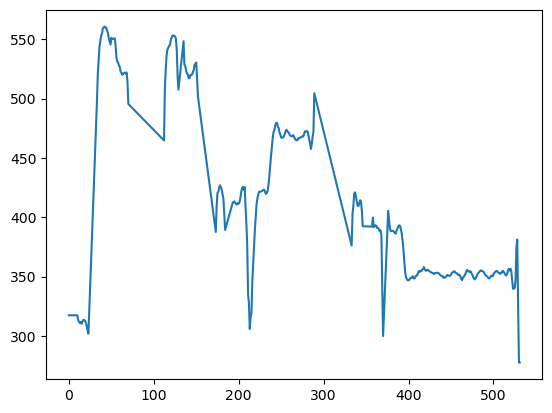

In [2]:
import matplotlib.pyplot as plt
x=[i for i in range(len(aaa[0]))]
plt.plot(x,aaa[0])
plt.show()

In [3]:
import torch
ass=torch.tensor((float('-inf'),2))
ccc=torch.nn.Softmax()(ass)
ccc

C:\Users\autumn\AppData\Local\Temp\ipykernel_187024\4074396011.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ccc=torch.nn.Softmax()(ass)


tensor([0., 1.])

In [5]:
import mido

'''
输出每个midi文件中的每个动作
'''
def send_msg():
    # 返回midi对象
    # 这里调用了mido的库里MidiFile()方法.
    # 并把文件名"DY_kanong.mid"传了进去.
    # 这里返回的mid就包含了所读取 "DY_kanong.mid" 的所有信息,
    # mid这个名字是我们自己起的,然后他就包含了midi文件的信息,以后操作它就行了.
    # 其实实现方法大概是用到了类的思想,以后mid这个变量就是类了,他有很多操作函数.通过点来调用.
    mid=mido.MidiFile("0000.mid")
    # 下面是一个循环,然后就是操作mid这个变量,调用tracks方法,
    # 这里tracks代表了音轨的东西,每条音轨通常情况下就是一个乐器.
    for i, track in enumerate(mid.tracks):             # 用于遍历,组合成索引序列.
        print('Track {}: {}'.format(i, track.name))    # 输出:Track 0: Piano 1
        # 上面一个循环是输出各条音轨,一个midi文件可以是好几条音轨合成的.每条音轨有一个乐器或多个乐器.
        # 下面这个循环是循环某一条音轨中的数据,输出音轨中的数据.
        # 音轨中记录的一系列钢琴按键按下和弹起的操作.
        for msg in track:
            # 输出每个动作.
            print(msg)


# 代表主函数
if __name__ == '__main__':
    # 调用函数
    send_msg()

Track 0: 
MetaMessage('set_tempo', tempo=500000, time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('end_of_track', time=1)
Track 1: 
program_change channel=0 program=0 time=0
note_on channel=0 note=59 velocity=100 time=0
note_on channel=0 note=59 velocity=0 time=44
note_on channel=0 note=62 velocity=100 time=0
note_on channel=0 note=62 velocity=0 time=75
note_on channel=0 note=58 velocity=100 time=369
note_on channel=0 note=57 velocity=100 time=146
note_on channel=0 note=58 velocity=0 time=0
note_on channel=0 note=57 velocity=0 time=101
note_on channel=0 note=58 velocity=100 time=0
note_on channel=0 note=58 velocity=0 time=61
note_on channel=0 note=59 velocity=100 time=0
note_on channel=0 note=59 velocity=0 time=220
note_on channel=0 note=60 velocity=100 time=0
note_on channel=0 note=60 velocity=0 time=220
note_on channel=0 note=60 velocity=100 time=0
note_on channel=0 note=60 velocity=0 time=150
no

In [1]:
{'phs':[],'diao':[],'f0s':[],'time':[],'speak':0,'notes':[],'sr':44100,'hops':[]}
import  json
import dl
from pypinyin import pinyin,Style
import pypinyin
with open('meta.json','r',encoding='utf8') as f:
    gggg=json.loads(f.read())
with open('opencpop-strict.txt','r',encoding='utf8') as d:
    dsdsd=d.read().strip().split('\n')
mapp={}
for i in dsdsd:
    kok=i.split('\t')
    mapp[kok[0]]=kok[1]

# gggg
# print(mapp)
spc=[]
for i in gggg:
    itnm=i['item_name']
    spo=itnm.split('#')
    spc.append(spo[0])
set(spc)
cccc={}
for idx,ij in enumerate(set(spc)):
    cccc[ij]=idx+1
cccc
for i in gggg:
    itnm=i['item_name']
    spo=itnm.split('#')
    spid=cccc[spo[0]]
    path=r'K:/dataa/新建文件夹/m4singer/'+itnm.replace('#0','/0')+'.wav'
    # print(path)
    foss=dl.get_f0(path,48000,'parselmouth',20,1000,512)
    jjjj={'phs':i['phs'],'diao':[],'f0s':list(foss[0]),'time':i['ph_dur'],'speak':spid,'notes':i['notes'],'sr':48000,'hops':512,'good':True}
    # print(jjjj)
    pypyp=pinyin(i['txt'], heteronym=True,style=Style.TONE3)
    isss=0
    for ij in pypyp:
        opc=0
        oop=0
        for isi in ij:

            wods =isi[:-1]
            print(isi)
            if isi[-1] in ['1','2','3','4']:

                ph_dio=int(isi[-1])
            else:
                ph_dio=5

            print(wods,ph_dio)


    # print(pypyp)

# print(pinyin('朝阳', heteronym=True))



100%|██████████| 20896/20896 [08:43<00:00, 39.89it/s]
